Script that takes nr data files, take signal in our direction, taper the start, propagate to the detectors, add noise, inject into detectors, plot.

We currently have
- setup + overhead + parameter initialization stuff
- lalsuite to extract inc=0 data
- taper using cos fcn in inc=0, replace data with tapered data, get t1, f1
- bilby propagating to detectors
- ifo bilby detector injection and adding noise
- some data set creations


We want to add:
- X tapering with three functions: cos, planck, hann
- X on inc=0 data only extract relevant time and frequency
- X then do lalsuite again on the general angle
- X then apply tapering to this signal
- X add tapering to the end of the signal - guess time by eye
- X add in padding
- do all the other stuff...
- ehh debug
- figure out what ringdown.fit needs, collect the right info in a csv


First some imports

In [134]:
import bilby 
from bilby.core.prior import Uniform
from bilby.gw.utils import asd_from_freq_series

import numpy as np
import matplotlib
matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
%matplotlib widget
import h5py
import lalsimulation as lalsim
import lal
import os

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar


Define some helpers:

In [135]:
#some inverse fourier transform helper 
def infft(frequency_domain_strain, sampling_frequency, length=None):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ----------
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.
    length: float
        length of the transformed axis of the output.
    """

    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain, n=length)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain

Some bibly overhead

In [136]:
# Specify the output directory and the name of the simulation.
# bilby setup stuff
outdir = "outdir"
label = "phenomXP"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

Set parameters from NR injection waveform

In [137]:
# Set the binary parameters of the NR inejection waveform
# this is the angle and distance to the source
inclination = 0 #!!!this needs to be 0 for tapering calc
luminosity_distance = 25.
distance = luminosity_distance * lal.PC_SI * 1.0e6
phiRef = 0.0

# our relevant file path - create separate folder system
filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
#filepath = 'chombo/GRChombo_BBSsol02_A17A17q100d17p000_Res40.h5'
#filepath = 'grav_wave_boson_star_testing_gr/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

Set up dictionary to store parameters. Populate it

In [138]:
# setting up dict to feed parameters into waveforms
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

# Metadata parameters masses
mtotal = 40.0 # set total mass scale - sim only has relative
# extract masses and convert to different units
m1 = f.attrs['mass1'] #code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2) #solar masses
mass_2 = m2 * mtotal / (m1 + m2)

# Choose extrinsic parameters

m1SI = mass_1 * lal.MSUN_SI #in kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

# Set sampling frequency of the data segment that we're going to inject the signal into
# just be aware of aliasing issues if too low
sampling_frequency = 4096.0  # Hz
deltaT = 1.0/sampling_frequency #cadence

# we need to set the lowest trustable frequency - set as lowest simulated frequency, scaled by the chosen mass
#CHANGE THIS AFTER DOING THE TAPERING
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  # this choice generates the whole NR waveforms from the beginning
fRef = 0   #beginning of the waveform
fStart = f_lower


In [139]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [140]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

# these are the steps we need to redo later, with a new inclination angle
h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [141]:
phase = np.arctan2(h_c.data.data, h_p.data.data)
unwrapped_phase = np.unwrap(phase)
unwrapped_phase_interp = UnivariateSpline(times, unwrapped_phase, k=3, s=0)
omega_interp = unwrapped_phase_interp.derivative() 
frequency = omega_interp(times) / (2.0 * np.pi)

safety = 0.1
sol = root_scalar(lambda t1: (1+safety)*(1./t1)-omega_interp(t1)/(2.0*np.pi),
                    x0 = 0.1, 
                    bracket=[0.01, 0.3])
t0, t1 = 0., sol.root
f0, f1 = omega_interp(t0)/(2.0*np.pi), omega_interp(t1)/(2.0*np.pi)
print(f"{t0=:.2e}, {f0=:.2e}, {t1=:.2e}, {f1=:.2e}")

minimum_frequency = f1


t0=0.00e+00, f0=2.66e+01, t1=4.09e-02, f1=2.69e+01


Now we extract the signal again with the other inc

In [142]:
inclination = 1.0471975512 # change to general angle

h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [143]:
# old window fcn

# def window(times, t0, t1):
#     taper = np.ones_like(times)
#     mask = (times >= t0) & (times <= t1)
#     taper[mask] = 0.5 * (1 - np.cos(np.pi * (times[mask] - t0) / (t1 - t0)))
#     return taper

In [144]:
from scipy.signal import windows

def window(times, t0, t1, kind='cosine', direction='on'):

    taper = np.ones_like(times)
    mask = (times >= t0) & (times <= t1)
    x = (times[mask] - t0) / (t1 - t0) # Normalized [0, 1] range

    if kind == 'cosine':
        taper[mask] = 0.5 * (1 - np.cos(np.pi * x))

    elif kind == "plancktaper":
        taper[mask] = np.array([
            1 / (np.exp((1 / xi) - (1 / (1 - xi))) + 1)
            if 0 < xi < 1 else (1.0 if xi >= 1 else 0.0)
            for xi in x
        ])
    
    else:
        # Generate a standard SciPy window and take only the first half
        n = np.count_nonzero(mask)
        try:
            wfunc = getattr(windows, kind)
            w = wfunc(n * 2)[:n] 
            w /= w.max()
            taper[mask] = w
        except AttributeError:
            raise ValueError(f"Unknown window type '{kind}'")

    if direction == 'off':
        # Flip the taper and set regions outside [t0, t1] appropriately
        taper[mask] = 1 - taper[mask]
        taper[times < t0] = 1.0
        taper[times > t1] = 0.0
    else:  # direction == 'on'
        taper[times < t0] = 0.0
        taper[times > t1] = 1.0

    return taper

In [145]:
window_funcs = ['cosine', 'plancktaper', 'hann']
taper_dict = {}        
tapered_hp_dict = {}   
tapered_hc_dict = {}

for wf in window_funcs:
    taper = window(times, t0, t1, kind=wf, direction='on')
    taper_dict[wf] = taper
    tapered_hp_dict[wf] = h_p.data.data * taper
    tapered_hc_dict[wf] = h_c.data.data * taper
    # move the tapering of the end to go here later

We plot the results

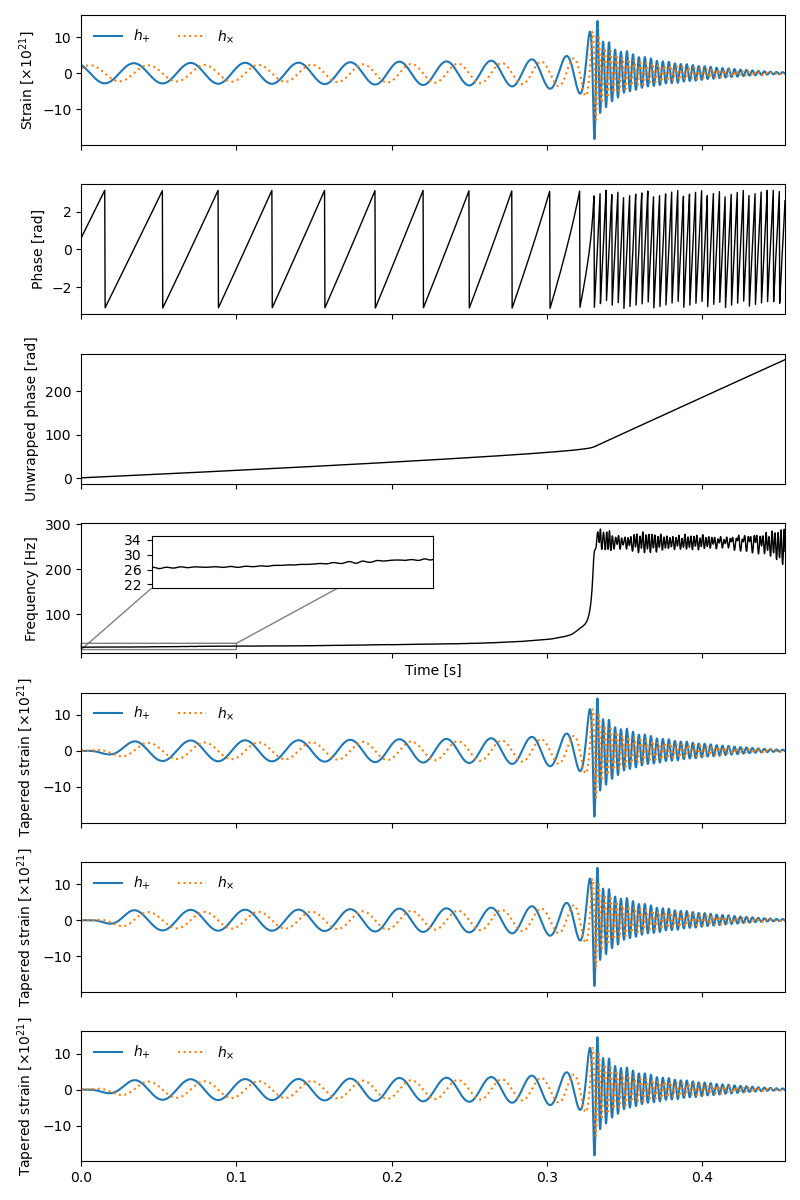

In [146]:
fig, axes = plt.subplots(nrows=7, sharex=True, figsize=(8, 12))

# plot initial signal
axes[0].plot(times, 1.0e21*h_p.data.data, ls='-', label=r'$h_{+}$')
axes[0].plot(times, 1.0e21*h_c.data.data, ls=':', label=r'$h_{\times}$')
axes[0].set_ylabel(r'Strain [$\times 10^{21}$]')
axes[0].set_xlim(times[0], times[-1])
axes[0].legend(loc='upper left', frameon=False, ncols=2)

# plot phase
axes[1].plot(times, phase, 'k-', lw=1)
axes[1].set_ylabel('Phase [rad]')

# unwrapped phase
axes[2].plot(times, unwrapped_phase, 'k-', lw=1)
axes[2].set_ylabel('Unwrapped phase [rad]')

# frequency
axes[3].plot(times, frequency, 'k-', lw=1)
axes[3].set_xlabel('Time [s]')
axes[3].set_ylabel('Frequency [Hz]')

# zoomed frequency window
x1, x2, y1, y2 = 0.0, 0.1, 21.0, 35.0  # subregion of the original image
axins = axes[3].inset_axes(
    [0.1, 0.5, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[], yticks=np.arange(22., 36.1, 4.))
axins.plot(times, frequency, 'k-', lw=1)
axes[3].indicate_inset_zoom(axins, edgecolor="black")

# after tapering
for (i,wf) in enumerate(window_funcs):
    tapered_hp = tapered_hp_dict[wf]
    tapered_hc = tapered_hc_dict[wf]
    axes[4+i].plot(times, 1.0e21*tapered_hp, ls='-', label=r'$h_{+}$')
    axes[4+i].plot(times, 1.0e21*tapered_hc, ls=':', label=r'$h_{\times}$')
    axes[4+i].set_ylabel(r'Tapered strain [$\times 10^{21}$]')
    axes[4+i].set_xlim(times[0], times[-1])
    axes[4+i].legend(loc='upper left', frameon=False, ncols=2)

plt.tight_layout()
plt.show()

We taper the end of the signal. I want to start the taper after the last max, which is at about 0.4518

In [147]:
# apply the taper function to the last part of the signal, start at the time index closest after 0.4518
# might have to increase, come back later
start_after = 0.4518
idx_start = np.searchsorted(times, start_after, side="right")

# choose start and end times for the end taper
t_start = times[idx_start] if idx_start < len(times) else times[-1]
t_end = times[-1]

if t_start >= t_end:
    raise ValueError(f"Invalid taper interval: t_start ({t_start}) >= t_end ({t_end})")

for wf in window_funcs:
    # build an end taper that goes from 0 -> 1 over [t_start, t_end] (using the same kind as the start taper)
    end_taper = window(times, t_start, t_end, kind=wf, direction='off')
    # combine with the existing start taper
    combined = taper_dict[wf] * end_taper

    # update the stored tapers and tapered signals
    taper_dict[wf] = taper_dict[wf] * end_taper
    tapered_hp_dict[wf] = tapered_hp_dict[wf] * end_taper
    tapered_hc_dict[wf] = tapered_hc_dict[wf] * end_taper

print(f"End taper applied starting at times[{idx_start}] = {t_start:.6f} s to {t_end:.6f} s for window types: {window_funcs}")

End taper applied starting at times[1851] = 0.451904 s to 0.453369 s for window types: ['cosine', 'plancktaper', 'hann']


In [148]:
# Plot original + newly tapered signals (plus, cross, amplitude)
# fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# # original waveforms
# orig_hp = h_p.data.data
# orig_hc = h_c.data.data
# ax[0].plot(times, orig_hp, color="k", lw=1.2, label="original h_plus")
# ax[1].plot(times, orig_hc, color="k", lw=1.2, label="original h_cross")

# # tapered waveforms
# for wf in window_funcs:
#     ax[0].plot(times, tapered_hp_dict[wf], label=f"{wf} (plus)", alpha=0.9)
#     ax[1].plot(times, tapered_hc_dict[wf], ls="--", label=f"{wf} (cross)", alpha=0.9)

# # labels, limits and legend
# ax[0].set_ylabel("Strain")
# ax[1].set_ylabel("Strain")
# ax[0].set_xlim(times[0], times[-1])
# for a in ax:
#     a.legend(loc="upper left", fontsize=9, frameon=False)

# plt.tight_layout()
# plt.show()

We plot the beginning and end of the plus and cross signal to see the effect of the tapering

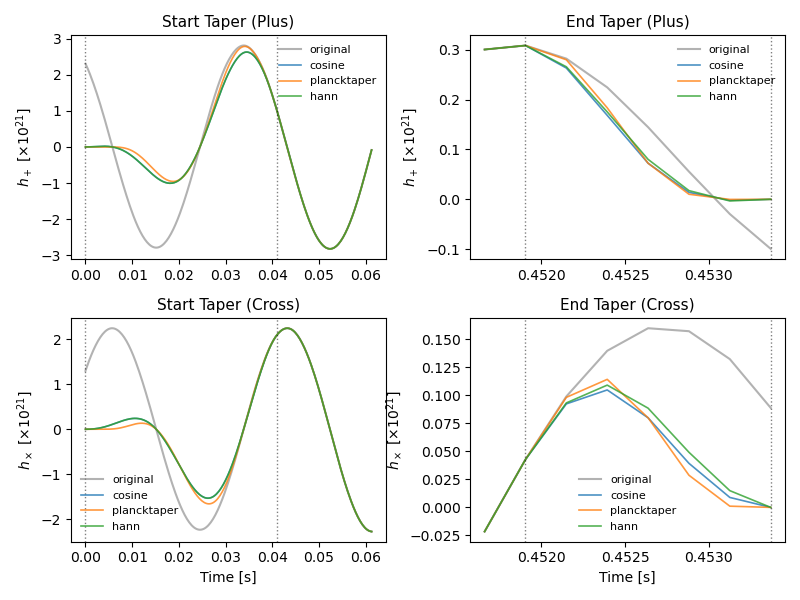

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2 rows (h+, hx) and 2 columns (start, end)
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Define narrow windows around the tapers
# Start taper window: show a bit before and after the taper
start_margin = (t1 - t0) * 0.5
start_mask = (times >= t0 - start_margin) & (times <= t1 + start_margin)

# End taper window: show a bit before and after the taper
end_margin = (t_end - t_start) * 0.3
end_mask = (times >= t_start - end_margin) & (times <= t_end + end_margin)

# Extract time arrays for each region
times_start = times[start_mask]
times_end = times[end_mask]

# Original waveforms
orig_hp = h_p.data.data
orig_hc = h_c.data.data

# Colors for different window types
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green

# Plot h+ (top row)
# Start region
ax[0, 0].plot(times_start, 1e21 * orig_hp[start_mask], color="gray", 
              lw=1.5, label="original", alpha=0.6)
for i, wf in enumerate(window_funcs):
    ax[0, 0].plot(times_start, 1e21 * tapered_hp_dict[wf][start_mask], 
                  label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])
ax[0, 0].axvline(t0, color='k', ls=':', alpha=0.5, lw=1)
ax[0, 0].axvline(t1, color='k', ls=':', alpha=0.5, lw=1)
ax[0, 0].set_ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
ax[0, 0].set_title("Start Taper (Plus)", fontsize=11)
ax[0, 0].legend(loc="best", fontsize=8, frameon=False)

# End region
ax[0, 1].plot(times_end, 1e21 * orig_hp[end_mask], color="gray", 
              lw=1.5, label="original", alpha=0.6)
for i, wf in enumerate(window_funcs):
    ax[0, 1].plot(times_end, 1e21 * tapered_hp_dict[wf][end_mask], 
                  label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])
ax[0, 1].axvline(t_start, color='k', ls=':', alpha=0.5, lw=1)
ax[0, 1].axvline(t_end, color='k', ls=':', alpha=0.5, lw=1)
ax[0, 1].set_ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
ax[0, 1].set_title("End Taper (Plus)", fontsize=11)
ax[0, 1].legend(loc="best", fontsize=8, frameon=False)

# Plot hx (bottom row)
# Start region
ax[1, 0].plot(times_start, 1e21 * orig_hc[start_mask], color="gray", 
              lw=1.5, label="original", alpha=0.6)
for i, wf in enumerate(window_funcs):
    ax[1, 0].plot(times_start, 1e21 * tapered_hc_dict[wf][start_mask], 
                  label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])
ax[1, 0].axvline(t0, color='k', ls=':', alpha=0.5, lw=1)
ax[1, 0].axvline(t1, color='k', ls=':', alpha=0.5, lw=1)
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
ax[1, 0].set_title("Start Taper (Cross)", fontsize=11)
ax[1, 0].legend(loc="best", fontsize=8, frameon=False)

# End region
ax[1, 1].plot(times_end, 1e21 * orig_hc[end_mask], color="gray", 
              lw=1.5, label="original", alpha=0.6)
for i, wf in enumerate(window_funcs):
    ax[1, 1].plot(times_end, 1e21 * tapered_hc_dict[wf][end_mask], 
                  label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])
ax[1, 1].axvline(t_start, color='k', ls=':', alpha=0.5, lw=1)
ax[1, 1].axvline(t_end, color='k', ls=':', alpha=0.5, lw=1)
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
ax[1, 1].set_title("End Taper (Cross)", fontsize=11)
ax[1, 1].legend(loc="best", fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

We pad the signal:

In [150]:
signal_length = len(times)
pad_length = signal_length // 2

# Get the time step (assuming uniform sampling)
dt = times[1] - times[0]

# Create new time array with padding
times_before = times[0] - np.arange(pad_length, 0, -1) * dt
times_after = times[-1] + np.arange(1, pad_length + 1) * dt
# Combine all times
times_padded = np.concatenate([times_before, times, times_after])
# shift to start at t=0
times_padded = times_padded-times_padded[0]

# Create padded versions of the tapered signals
padded_hp_dict = {}
padded_hc_dict = {}
padded_taper_dict = {}

for wf in window_funcs:
    # Pad with zeros on each side
    padded_hp_dict[wf] = (np.pad(tapered_hp_dict[wf], pad_length, mode='constant', constant_values=0))
    padded_hc_dict[wf] = (np.pad(tapered_hc_dict[wf], pad_length, mode='constant', constant_values=0))
    padded_taper_dict[wf] = (np.pad(taper_dict[wf], pad_length, mode='constant', constant_values=0))

print(f"Original signal length: {signal_length} points ({times[0]:.4f} s to {times[-1]:.4f} s)")
print(f"Padded signal length: {len(times_padded)} points ({times_padded[0]:.4f} s to {times_padded[-1]:.4f} s)")
print(f"Padding: {pad_length} points ({pad_length * dt:.4f} s) on each side")
print(f"Signal now occupies {100 * signal_length / len(times_padded):.1f}% of total length")

Original signal length: 1858 points (0.0000 s to 0.4534 s)
Padded signal length: 3716 points (0.0000 s to 0.9070 s)
Padding: 929 points (0.2268 s) on each side
Signal now occupies 50.0% of total length


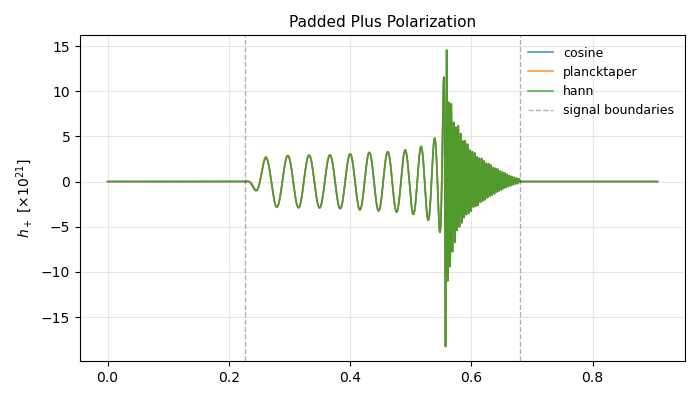

In [156]:
# Plot the padded signals
fig = plt.figure(figsize=(7, 4))

# Plot h+ (top)
for i, wf in enumerate(window_funcs):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    plt.plot(times_padded, 1e21 * padded_hp_dict[wf], 
               label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])

# Mark where original signal starts and ends
plt.axvline(times_padded[pad_length], color='k', ls='--', alpha=0.3, lw=1, label='signal boundaries')
plt.axvline(times_padded[pad_length + signal_length - 1], color='k', ls='--', alpha=0.3, lw=1)
plt.ylabel(f"$h_+$ [$\\times 10^{{21}}$]")
plt.title("Padded Plus Polarization", fontsize=11)
plt.legend(loc="best", fontsize=9, frameon=False)
plt.grid(alpha=0.3)

# Plot hx (bottom)
# for i, wf in enumerate(window_funcs):
#     ax[1].plot(times_padded, 1e21 * padded_hc_dict[wf], 
#                label=f"{wf}", alpha=0.8, lw=1.2, color=colors[i])

# ax[1].axvline(times_padded[pad_length], color='k', ls='--', alpha=0.3, lw=1, label='signal boundaries')
# ax[1].axvline(times_padded[pad_length + signal_length - 1], color='k', ls='--', alpha=0.3, lw=1)
# ax[1].set_xlabel("Time [s]")
# ax[1].set_ylabel(f"$h_\\times$ [$\\times 10^{{21}}$]")
# ax[1].set_title("Padded Cross Polarization", fontsize=11)
# ax[1].legend(loc="best", fontsize=9, frameon=False)
# ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [157]:
def create_nr_injection(times_array, hp_array, hc_array):
    """
    Factory function that creates a custom NR injection function
    with specific time series data.
    """
    def nr_injection(time):
            
        hp = np.interp(time, times_array, hp_array)
        hc = np.interp(time, times_array, hc_array)
        return {"plus": hp, "cross": hc}
    
    return nr_injection

In [158]:
times_padded[0]

np.float64(0.0)

We use bilby:

In [159]:
# propagate and inject each tapered signal
# create dict to store the data
original_hp = np.copy(h_p.data.data)
original_hc = np.copy(h_c.data.data)
ifo_data_dict = {}

# pick one to get injection parameters from
# these are all about the peak of the signal, so is independent of taper type

preprocessed_hp = padded_hp_dict[window_funcs[0]]
preprocessed_hc = padded_hc_dict[window_funcs[0]]

amplitude = np.sqrt(preprocessed_hp**2 + preprocessed_hc**2)
peak_id = np.argmax(amplitude)
peak = times_padded[peak_id]

hplus = preprocessed_hp[peak_id]
hcross = preprocessed_hc[peak_id]
phase_merger = np.arctan2(-hcross,hplus) + np.pi


#duration = times_padded[-1]
start_time = times_padded[0]
signal_start_time = times_padded[pad_length]
duration = len(times_padded) / sampling_frequency

#TRY TO SET EITHER START TIME OR GEOCENTRIC TIME TO THE START OF THE SIGNAL ITSELF

np.random.seed(88170235)
injection_parameters = dict(
    mass_1=mass_1,
    mass_2=mass_2,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.0,
    tilt_2=0.0,
    phi_12=0.0,
    phi_jl=0.0,
    luminosity_distance=luminosity_distance,
    theta_jn=inclination,
    psi=np.pi/2,
    phase=phase_merger,
    geocent_time=peak,
    ra=1.375,
    dec=-1.2108
)

#DEBUGGING
print(f"times_padded[0] = {times_padded[0]}")
print(f"times_padded[-1] = {times_padded[-1]}")  
print(f"peak = {peak}")
print(f"pad_length = {pad_length}")
print(f"Index of peak = {peak_id}")
print(f"Index where original signal starts = {pad_length}")
print(f"Time where original signal starts = {times_padded[pad_length]}")

print(f"waveform generator start_time = ?")
print(f"IFO start_time = {start_time}")  
print(f"duration = {duration}")
print(f"geocent_time = {peak}")

for wf in window_funcs:
    preprocessed_hp = padded_hp_dict[wf]
    preprocessed_hc = padded_hc_dict[wf]
    # bibly assumes a signal centered at 0 and then applies a geocentric time shift, so we must shift our signal accordingly
    # roll the arrays so the peak is at index 0
    hp_rolled = np.roll(preprocessed_hp, -peak_id)
    hc_rolled = np.roll(preprocessed_hc, -peak_id)

    nr_injection_wf = create_nr_injection(times_padded, hp_rolled, hc_rolled)

    # propagate to interferometers
    waveform = bilby.gw.waveform_generator.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
            time_domain_source_model=nr_injection_wf, start_time=0);

    # get time and frequency domain strains and arrays
    time_domain = waveform.time_domain_strain(parameters=injection_parameters);
    time_array = waveform.time_array

    fr_domain = waveform.frequency_domain_strain(parameters=injection_parameters);
    fr_array = waveform.frequency_array

    # these still look good, no weird shifts
    #plot time domain strain
    # plt.figure(figsize=(10, 4))
    # plt.plot(time_array, 1.0e21*time_domain['plus'], label='$h_{+}$')
    # plt.plot(time_array, 1.0e21*time_domain['cross'], label='$h_{\\times}$')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Strain [$\\times 10^{21}$]')
    # plt.title(f'Time Domain Strain for {wf} window')
    # plt.legend()
    # plt.grid()
    # plt.show()

    # plot frequency domain strain
    # plt.figure(figsize=(10, 4))
    # plt.loglog(fr_array, np.abs(fr_domain['plus']), label='$|\\tilde{h}_{+}|$')
    # plt.loglog(fr_array, np.abs(fr_domain['cross']), label='$|\\tilde{h}_{\\times}|$')
    # plt.xlabel('Frequency [Hz]')
    # plt.ylabel('Strain Amplitude')
    # plt.title(f'Frequency Domain Strain for {wf} window')
    # plt.legend()
    # plt.grid()
    # plt.show()

    # create ifos and inject signal and noise
    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1']);
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time);
    ifos.inject_signal(waveform_generator=waveform,
                    parameters=injection_parameters, raise_error=False);

    #store results ifos data in a preprocessed data dict to create time series data later
    ifo_data_dict[wf] = ifos   

14:33 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.9072265625, sampling_frequency=4096.0, start_time=0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})


14:33 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.9072265625s
14:33 bilby INFO    : Injected signal in H1:
14:33 bilby INFO    :   optimal SNR = 419.29
14:33 bilby INFO    :   matched filter SNR = 419.07+1.45j
14:33 bilby INFO    :   mass_1 = 20.0
14:33 bilby INFO    :   mass_2 = 20.0
14:33 bilby INFO    :   a_1 = 0.0
14:33 bilby INFO    :   a_2 = 0.0
14:33 bilby INFO    :   tilt_1 = 0.0
14:33 bilby INFO    :   tilt_2 = 0.0
14:33 bilby INFO    :   phi_12 = 0.0
14:33 bilby INFO    :   phi_jl = 0.0
14:33 bilby INFO    :   luminosity_distance = 25.0
14:33 bilby INFO    :   theta_jn = 1.0471975512
14:33 bilby INFO    :   psi = 1.5707963267948966
14:33 bilby INFO    :   phase = 5.972915950902314
14:33 bilby INFO    :   geocent_time = 0.5576171875
14:33 bilby INFO    :   ra = 1.375
14:33 bilby INFO    :   dec = -1.2108


times_padded[0] = 0.0
times_padded[-1] = 0.906982421875
peak = 0.5576171875
pad_length = 929
Index of peak = 2284
Index where original signal starts = 929
Time where original signal starts = 0.226806640625
waveform generator start_time = ?
IFO start_time = 0.0
duration = 0.9072265625
geocent_time = 0.5576171875


14:33 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector L1 has a duration of 0.9072265625s
14:33 bilby INFO    : Injected signal in L1:
14:33 bilby INFO    :   optimal SNR = 292.96
14:33 bilby INFO    :   matched filter SNR = 294.25+0.73j
14:33 bilby INFO    :   mass_1 = 20.0
14:33 bilby INFO    :   mass_2 = 20.0
14:33 bilby INFO    :   a_1 = 0.0
14:33 bilby INFO    :   a_2 = 0.0
14:33 bilby INFO    :   tilt_1 = 0.0
14:33 bilby INFO    :   tilt_2 = 0.0
14:33 bilby INFO    :   phi_12 = 0.0
14:33 bilby INFO    :   phi_jl = 0.0
14:33 bilby INFO    :   luminosity_distance = 25.0
14:33 bilby INFO    :   theta_jn = 1.0471975512
14:33 bilby INFO    :   psi = 1.5707963267948966
14:33 bilby INFO    :   phase = 5.972915950902314
14:33 bilby INFO    :   geocent_time = 0.5576171875
14:33 bilby INFO    :   ra = 1.375
14:33 bilby INFO    :   dec = -1.2108
14:33 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.9072265625, sampli

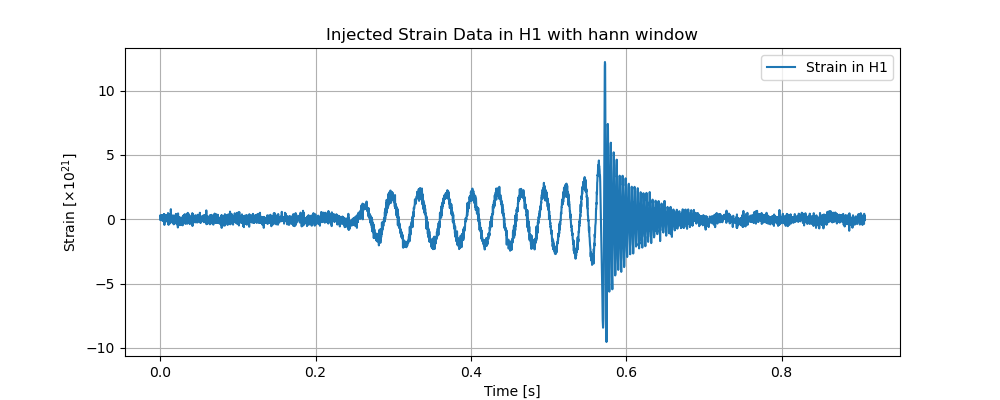

In [160]:
# try some plotting of the ifo data
ifo = ifo_data_dict[window_funcs[0]][0]  # pick one window type to plot
times_ifo = ifo.time_array
strain = ifo.time_domain_strain

plt.figure(figsize=(10, 4))
plt.plot(times_ifo, 1.0e21*strain, label=f'Strain in {ifo.name}')
plt.xlabel('Time [s]')
plt.ylabel('Strain [$\\times 10^{21}$]')
plt.title(f'Injected Strain Data in {ifo.name} with {wf} window')
plt.legend()
plt.grid()
plt.show()

Now we want to generate the relevant datasets to at least get a new strain timeseries. Need to adapt this to work for each fcn

In [162]:
# Generate some intermmediate plot files
# these are different versions of datafiles, prob wont need most of them
start_time = 0
end_time = duration

for wf in window_funcs:
    ifos = ifo_data_dict[wf]
    for ifo in ifos:
        time_idxs = (
                    (ifo.time_array >= start_time) &
                    (ifo.time_array <= end_time)
                ) #returns a boolean array of interferometer time

        frequency_idxs = np.where(ifo.frequency_mask)[0]
        frequency_idxs = frequency_idxs[::max(1, len(frequency_idxs) // 4000)]
        plot_times = ifo.time_array[time_idxs]
        plot_frequencies = ifo.frequency_array[frequency_idxs]

        frequency_window_factor = (
                    np.sum(ifo.frequency_mask)
                    / len(ifo.frequency_mask)
                ) # create a window factor using a masking array for limiting the frequency band 
        hf_d = asd_from_freq_series(
                    ifo.frequency_domain_strain[frequency_idxs],
                    1 / ifo.strain_data.duration)
        ht_d = np.fft.irfft(ifo.whitened_frequency_domain_strain
                                * np.sqrt(np.sum(ifo.frequency_mask))
                                / frequency_window_factor, n=len(time_idxs)
                            )[time_idxs]
        
        # Save data stream here
        np.savetxt("outdir/"+ifo.name+"_time_data_stream.dat", np.column_stack([plot_times, ht_d]), delimiter='   ')

        np.savetxt("outdir/"+ifo.name+"_frequency_data_stream.dat", np.column_stack([plot_frequencies, ifo.frequency_domain_strain[frequency_idxs]]), delimiter='   ')

        np.savetxt("outdir/"+ifo.name+"_frequency_asd_data_stream.dat", np.column_stack([plot_frequencies, hf_d]), delimiter='   ')

        hf_inj = waveform.frequency_domain_strain(injection_parameters)
        hf_inj_det = ifo.get_detector_response(hf_inj, injection_parameters)
        ht_inj_det = infft(hf_inj_det * np.sqrt(2. / ifo.sampling_frequency) /
                                ifo.amplitude_spectral_density_array,
                                sampling_frequency, len(time_idxs))[time_idxs]
        
        # Try this (raw detector response without whitening):
        ht_inj_det_raw = infft(hf_inj_det, sampling_frequency, len(time_idxs))[time_idxs]

        # Save injections to file 
        np.savetxt("outdir/"+ifo.name+"_time_injection_waveform.dat", np.column_stack([plot_times, ht_inj_det]), delimiter='   ')

        np.savetxt("outdir/"+ifo.name+"_frequency_injection_waveform.dat", np.column_stack([plot_frequencies, hf_inj_det[frequency_idxs]]), delimiter='   ')

        np.savetxt("outdir/"+ifo.name+"_frequency_asd_injection_waveform.dat", np.column_stack([plot_frequencies, asd_from_freq_series(hf_inj_det[frequency_idxs], 1 / ifo.strain_data.duration)]), delimiter='   ')

/tmp/ipykernel_130530/269115341.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[4].legend()


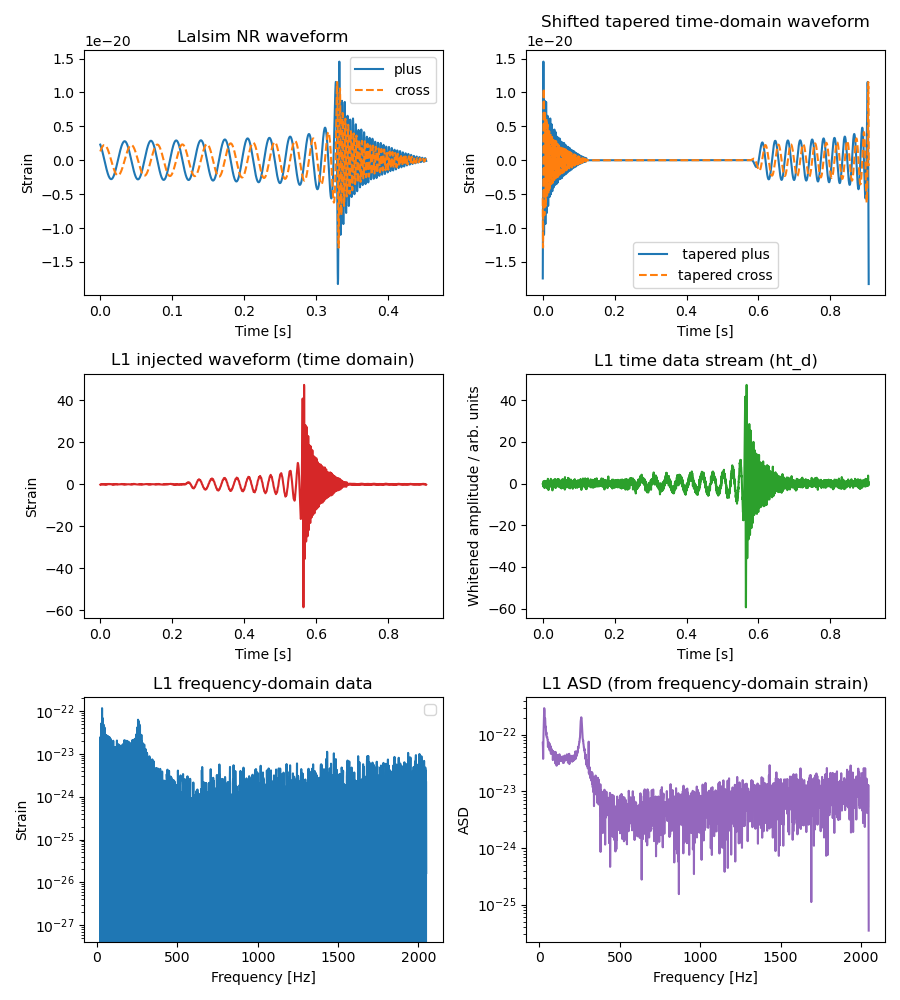

In [168]:
fig, axes = plt.subplots(3, 2, figsize=(9, 10))
ax = axes.flatten()
ifo = ifos[1]  # Just plot for the first interferometer

# 2) Lalsim NR waveform (plus & cross)
ax[0].plot(times, original_hp, label="plus")
ax[0].plot(times, original_hc, ls="--", label="cross")
ax[0].set_title("Lalsim NR waveform")
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Strain")
ax[0].legend()

# 2) Tapered time-domain waveform (plus & cross). Output from Bilby waveform generator
ax[1].plot(time_array, time_domain["plus"], label=" tapered plus")
ax[1].plot(time_array, time_domain["cross"], ls="--", label="tapered cross")
ax[1].set_title("Shifted tapered time-domain waveform")
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Strain")
ax[1].legend()

# 3) Detector injected time-series (ht_inj_det)
# what am I actually plotting here? Is it what I get before or after injection?
# it is after a fourier transform at least
# think it is what is actually sent into the detector at least, right before we add noise. So there is an issue with this shape.
ax[2].plot(plot_times, ht_inj_det, color="C3")
ax[2].set_title(f"{ifo.name} injected waveform (time domain)")
ax[2].set_xlabel("Time [s]")
ax[2].set_ylabel("Strain")

# 4) Detector time-series (ht_d)
ax[3].plot(plot_times, ht_d, color="C2")
ax[3].set_title(f"{ifo.name} time data stream (ht_d)")
ax[3].set_xlabel("Time [s]")
ax[3].set_ylabel("Whitened amplitude / arb. units")

# 5) Detector frequency-domain data
ax[4].plot(plot_frequencies, ifo.frequency_domain_strain[frequency_idxs])
ax[4].set_yscale("log")
ax[4].set_title(f"{ifo.name} frequency-domain data")
ax[4].set_xlabel("Frequency [Hz]")
ax[4].set_ylabel("Strain")
ax[4].legend()

# 6) ASD from interferometer frequency-domain strain (subset used for plotting)
ax[5].plot(plot_frequencies, hf_d, color="C4")
ax[5].set_yscale("log")
ax[5].set_title(f"{ifo.name} ASD (from frequency-domain strain)")
ax[5].set_xlabel("Frequency [Hz]")
ax[5].set_ylabel("ASD")

plt.tight_layout()
plt.show()

Now we might have to save more metadata to pass to ringdown later. We should send the L1 time data stream - so injected signal with noise.

In [176]:
import pandas as pd

# 1. Initialize dictionary with the common time array (assuming all use the same time grid)
# We grab the time from the first available injection
first_wf = window_funcs[0]
time_array = ifo_data_dict[first_wf][0].time_array 
data_dict = {'time': time_array}

# 2. Loop through your window functions and collect strain
for wf in window_funcs:
    ifos = ifo_data_dict[wf]
    for ifo in ifos:
        # Create a unique column name like 'H1_planck' or 'L1_cos'
        col_name = f"{ifo.name}_{wf}"
        data_dict[col_name] = ifo.time_domain_strain

# 3. Save to a single CSV
df = pd.DataFrame(data_dict)
df.to_csv('injections_all_tapers.csv', index=False)
print("Saved all tapers to 'injections_all_tapers.csv'")

print("\n=== METADATA FOR RINGDOWN FIT ===")
print(f"t0 (geocent_time): {injection_parameters['geocent_time']}")
print(f"ra:                {injection_parameters['ra']}")
print(f"dec:               {injection_parameters['dec']}")
print(f"psi:               {injection_parameters['psi']}")
print(f"duration:          {duration}")
print("=================================")

Saved all tapers to 'injections_all_tapers.csv'

=== METADATA FOR RINGDOWN FIT ===
t0 (geocent_time): 0.5576171875
ra:                1.375
dec:               -1.2108
psi:               1.5707963267948966
duration:          0.9072265625
